# **Modelo para previsão de tempo de ciclo** 

## 1. Problema de negócio

Antecipar ações de mitigação ou eliminação de tendências de aumento do tempo de ciclo no proesso Coca-Cola.

## 2. Coleta dos dados

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", color_codes=True)
style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Importação dos dados brutos a partir da planilha do google sheets
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1K2gttQztUmuMdg_E69xGNE9ykotev-jUupzvv3lk_pY/edit#gid=929468129')
sheet = wb.worksheet('(1) CFD_DB')
data = sheet.get_all_records(head=3)
dados = pd.DataFrame(data)
dados

,Data,Dia Semana,Semana,Tamanho Backlog,Canceled,Done,Ready to Pub (Prod),Published in Test,Ready to Pub (Test),Code Review,On Hold,Blocked,In Dev,To Do,Ready for Dev,Bloqueado Backlog,In Refinement,Open,Closed_Qt,WIP_Qt,New_Arrival,TC_Dia,TC_Media,Dif_Dias,
0,01/11/2019,6,44,1173,73,1009,21,1,0,3,3,3,4,8,0,0,2,46,3,35,7,"11,7","11,7",151,
1,04/11/2019,2,45,1189,73,1033,3,0,0,4,6,2,3,11,0,0,2,52,24,18,16,"0,8","6,2",148,
2,05/11/2019,3,45,1208,73,1038,5,0,1,3,2,2,5,13,0,0,11,55,5,18,19,"3,6","5,3",147,
3,06/11/2019,4,45,1225,74,1047,1,1,7,9,2,2,3,20,0,0,3,56,10,25,17,"2,5","4,6",146,
4,07/11/2019,5,45,1229,74,1056,1,0,7,7,2,2,6,21,0,0,1,52,9,25,4,"2,8","4,3",145,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,24/03/2020,3,13,2302,200,1903,1,11,0,3,11,6,5,25,22,13,3,99,18,37,46,"2,1","7,4",7,
102,25/03/2020,4,13,2308,200,1911,0,8,3,7,10,6,8,18,22,13,3,99,8,42,6,"5,3","7,9",6,
103,26/03/2020,5,13,2318,200,1924,0,6,2,9,4,9,8,18,22,13,4,99,13,38,10,"2,9","4,6",5,
104,27/03/2020,6,13,2330,202,1928,0,8,12,5,8,9,4,18,22,13,3,98,6,46,12,"7,7","5,1",4,


## 3. Análise exploratória

In [4]:
# Verificação de dados faltantes
dados.isna().sum()

Data                   0
Dia Semana             0
Semana                 0
Tamanho Backlog        0
Canceled               0
Done                   0
Ready to Pub (Prod)    0
Published in Test      0
Ready to Pub (Test)    0
Code Review            0
On Hold                0
Blocked                0
In Dev                 0
To Do                  0
Ready for Dev          0
Bloqueado Backlog      0
In Refinement          0
Open                   0
Closed_Qt              0
WIP_Qt                 0
New_Arrival            0
TC_Dia                 6
TC_Media               0
Dif_Dias               0
                       0
dtype: int64

In [0]:
# Remoção dos dados faltantes
dados.dropna(axis=0, inplace=True)

In [0]:
# Ajustando valores para float
def decimal_point_replace(valor):
  return valor.replace(",", ".")

dados['TC_Dia'] = dados['TC_Dia'].map(decimal_point_replace).astype(float)
dados['TC_Media'] = dados['TC_Media'].map(decimal_point_replace).astype(float)

In [7]:
# Parâmetros estatísticos dos dados (estatística descritiva)
dados.describe()

,Dia Semana,Semana,Tamanho Backlog,Canceled,Done,Ready to Pub (Prod),Published in Test,Ready to Pub (Test),Code Review,On Hold,Blocked,In Dev,To Do,Ready for Dev,Bloqueado Backlog,In Refinement,Open,Closed_Qt,WIP_Qt,New_Arrival,TC_Dia,TC_Media,Dif_Dias
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000,100.000000
mean,4.030000,23.350000,1723.660000,124.660000,1467.490000,1.850000,4.560000,4.650000,6.980000,4.650000,5.800000,5.640000,20.480000,11.620000,4.22000,4.260000,56.800000,10.74000,34.130000,11.770000,6.184000,6.319,75.480000
std,1.445683,20.381401,355.586419,33.985208,275.107747,3.685557,4.461553,4.524624,4.355375,2.914176,4.052683,1.811969,11.360467,5.568272,6.61431,3.860235,31.093862,7.34107,10.781255,10.674103,7.492471,3.009,44.008144
min,2.000000,1.000000,1173.000000,73.000000,1009.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,2.000000,0.000000,0.00000,0.000000,3.000000,1.00000,15.000000,-5.000000,0.700000,1.500,1.000000
25%,3.000000,6.000000,1396.250000,102.000000,1220.250000,0.000000,1.000000,1.000000,3.000000,3.000000,3.000000,4.000000,9.750000,6.000000,0.00000,1.000000,24.000000,6.00000,25.750000,5.750000,2.275000,4.200,39.750000
50%,4.000000,11.500000,1731.500000,123.000000,1464.000000,1.000000,3.500000,3.000000,6.000000,4.000000,5.000000,5.000000,22.000000,11.500000,0.00000,3.500000,58.000000,9.00000,32.000000,9.000000,3.600000,5.400,74.500000
75%,5.000000,47.000000,2026.000000,140.250000,1706.000000,2.000000,7.000000,7.000000,10.000000,6.000000,7.000000,7.000000,28.000000,16.000000,12.25000,7.000000,84.000000,15.00000,39.000000,14.000000,7.325000,8.000,113.750000
max,6.000000,53.000000,2342.000000,204.000000,1941.000000,21.000000,19.000000,17.000000,18.000000,12.000000,18.000000,10.000000,48.000000,22.000000,19.00000,19.000000,129.000000,36.00000,60.000000,50.000000,44.000000,13.200,151.000000


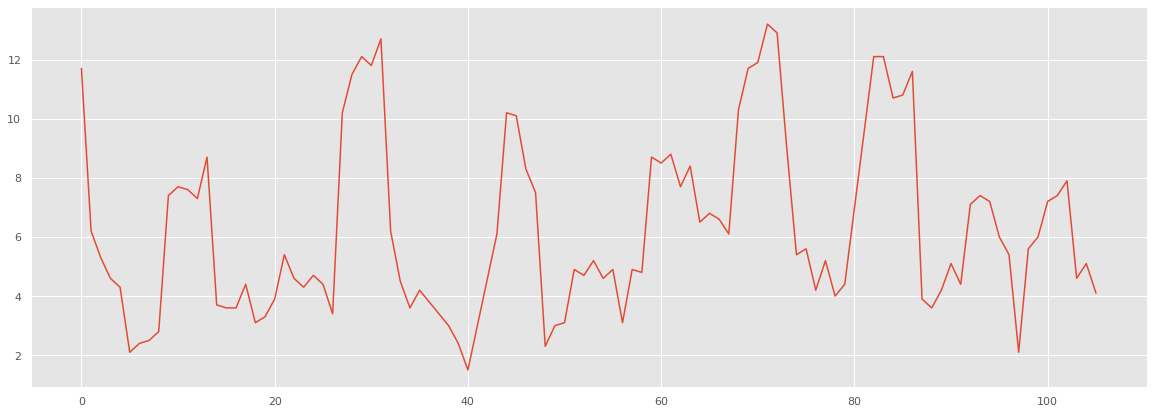

In [8]:
dados['TC_Media'].plot(figsize=(20, 7))

# 4. Modelagem

In [10]:
dados.columns

Index(['Data', 'Dia Semana', 'Semana', 'Tamanho Backlog', 'Canceled', 'Done',
       'Ready to Pub (Prod)', 'Published in Test', 'Ready to Pub (Test)',
       'Code Review', 'On Hold', 'Blocked', 'In Dev', 'To Do', 'Ready for Dev',
       'Bloqueado Backlog', 'In Refinement', 'Open', 'Closed_Qt', 'WIP_Qt',
       'New_Arrival', 'TC_Dia', 'TC_Media', 'Dif_Dias', ''],
      dtype='object')

In [12]:
# Exclusão de variáveis
dados2 = dados.drop(labels=['Data', 'Dif_Dias', ''], axis=1)

dados2.head(5)

,Dia Semana,Semana,Tamanho Backlog,Canceled,Done,Ready to Pub (Prod),Published in Test,Ready to Pub (Test),Code Review,On Hold,Blocked,In Dev,To Do,Ready for Dev,Bloqueado Backlog,In Refinement,Open,Closed_Qt,WIP_Qt,New_Arrival,TC_Dia,TC_Media
0,6,44,1173,73,1009,21,1,0,3,3,3,4,8,0,0,2,46,3,35,7,11.7,11.7
1,2,45,1189,73,1033,3,0,0,4,6,2,3,11,0,0,2,52,24,18,16,0.8,6.2
2,3,45,1208,73,1038,5,0,1,3,2,2,5,13,0,0,11,55,5,18,19,3.6,5.3
3,4,45,1225,74,1047,1,1,7,9,2,2,3,20,0,0,3,56,10,25,17,2.5,4.6
4,5,45,1229,74,1056,1,0,7,7,2,2,6,21,0,0,1,52,9,25,4,2.8,4.3


In [13]:
# Criação da variável preditiva ( TC_Media é a média móvel de 5 dias anteriores)
dias_prever = 3
dados2['y'] = dados2['TC_Media'].shift(-dias_prever)
dados2.dropna(inplace=True)
dados2

,Dia Semana,Semana,Tamanho Backlog,Canceled,Done,Ready to Pub (Prod),Published in Test,Ready to Pub (Test),Code Review,On Hold,Blocked,In Dev,To Do,Ready for Dev,Bloqueado Backlog,In Refinement,Open,Closed_Qt,WIP_Qt,New_Arrival,TC_Dia,TC_Media,y
0,6,44,1173,73,1009,21,1,0,3,3,3,4,8,0,0,2,46,3,35,7,11.7,11.7,4.6
1,2,45,1189,73,1033,3,0,0,4,6,2,3,11,0,0,2,52,24,18,16,0.8,6.2,4.3
2,3,45,1208,73,1038,5,0,1,3,2,2,5,13,0,0,11,55,5,18,19,3.6,5.3,2.1
3,4,45,1225,74,1047,1,1,7,9,2,2,3,20,0,0,3,56,10,25,17,2.5,4.6,2.4
4,5,45,1229,74,1056,1,0,7,7,2,2,6,21,0,0,1,52,9,25,4,2.8,4.3,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,5,12,2247,198,1873,0,3,6,8,9,7,6,36,16,15,3,67,2,39,3,19.5,5.6,7.4
99,6,12,2251,199,1880,0,7,5,8,8,8,5,25,22,15,3,66,8,41,4,5.1,6.0,7.9
100,2,13,2256,200,1885,0,8,6,9,9,8,6,24,22,13,3,63,6,46,5,7.7,7.2,4.6
101,3,13,2302,200,1903,1,11,0,3,11,6,5,25,22,13,3,99,18,37,46,2.1,7.4,5.1


In [14]:
# Normalizando
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

'''scaler = MinMaxScaler(feature_range=(0, 1))
scaler_TC = MinMaxScaler(feature_range=(0, 1))
scaler_TC.fit([dados2['TC_Media']])
dados3 = pd.DataFrame(data=scaler.fit(dados2).transform(dados2), index=dados2.index, columns=dados2.columns)
'''

dados3 = dados2

dados3.describe()

,Dia Semana,Semana,Tamanho Backlog,Canceled,Done,Ready to Pub (Prod),Published in Test,Ready to Pub (Test),Code Review,On Hold,Blocked,In Dev,To Do,Ready for Dev,Bloqueado Backlog,In Refinement,Open,Closed_Qt,WIP_Qt,New_Arrival,TC_Dia,TC_Media,y
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.00000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,4.020619,23.659794,1704.907216,122.268041,1453.154639,1.907216,4.453608,4.618557,6.979381,4.577320,5.742268,5.639175,20.463918,11.329897,3.948454,4.28866,55.536082,10.721649,33.917526,11.783505,6.239175,6.372165,6.275258
std,1.435991,20.619008,344.304616,31.595924,266.695181,3.727942,4.479166,4.521807,4.413472,2.904146,4.088292,1.815360,11.511825,5.392359,6.529375,3.91567,30.711379,7.422856,10.860546,10.838038,7.590668,3.039180,3.003749
min,2.000000,1.000000,1173.000000,73.000000,1009.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.00000,3.000000,1.000000,15.000000,-5.000000,0.700000,1.500000,1.500000
25%,3.000000,6.000000,1394.000000,102.000000,1212.000000,0.000000,1.000000,1.000000,3.000000,3.000000,3.000000,4.000000,9.000000,6.000000,0.000000,1.00000,24.000000,6.000000,25.000000,5.000000,2.200000,4.200000,4.200000
50%,4.000000,11.000000,1724.000000,122.000000,1451.000000,1.000000,3.000000,3.000000,6.000000,4.000000,5.000000,5.000000,22.000000,11.000000,0.000000,4.00000,58.000000,9.000000,32.000000,8.000000,3.600000,5.400000,5.400000
75%,5.000000,47.000000,2001.000000,139.000000,1684.000000,2.000000,7.000000,7.000000,10.000000,6.000000,7.000000,7.000000,28.000000,16.000000,10.000000,7.00000,82.000000,15.000000,38.000000,14.000000,7.300000,8.300000,7.900000
max,6.000000,53.000000,2308.000000,200.000000,1911.000000,21.000000,19.000000,17.000000,18.000000,12.000000,18.000000,10.000000,48.000000,22.000000,19.000000,19.00000,129.000000,36.000000,60.000000,50.000000,44.000000,13.200000,13.200000


In [0]:
# Segregação de dados de treino e teste

# Separação de x e y para o modelo
x = dados3.drop('y', axis=1)
y = dados3['y']

# Separação em treino e validação
# 90% para treino (usado no treinamento do modelo)
# 10% para validação (usado para validar o modelo)
from sklearn.model_selection import train_test_split

x_treino, x_valid, y_treino, y_valid = train_test_split(x, y, train_size=0.9)

In [0]:
# Função para apresentar as métricas do modelo
def get_metrics(y_true, y_predict):
  from sklearn.metrics import  r2_score, max_error, mean_absolute_error, mean_squared_error, accuracy_score
  R2 = r2_score(y_true, y_predict)
  MAE = mean_absolute_error(y_true, y_predict)
  MaxError = max_error(y_true, y_predict)
  MSE = mean_squared_error(y_true, y_predict)
  metrics = {'R2':R2, 'MSE': MSE, 'MAE':MAE, 'MaxError':MaxError}
  return metrics

In [26]:
# Modelos
%%time

# Linear Regression
from sklearn.linear_model import LinearRegression
Regress = LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1).fit(x_treino, y_treino)
Regress_predict = Regress.predict(x_valid)

# Support Vector Machine
from sklearn import svm
SVM = svm.SVR(C=1.0, cache_size=2000, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False).fit(x_treino, y_treino)
SVM_predict = SVM.predict(x_valid)

# Lasso
from sklearn import linear_model
Lasso = linear_model.Lasso(alpha=0.1).fit(x_treino, y_treino)
Lasso_predict = Lasso.predict(x_valid)

# Elastic-Net
from sklearn.linear_model import ElasticNet
ElasticN = ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False).fit(x_treino, y_treino)
ElasticN_predict = ElasticN.predict(x_valid)

# Bayesian Ridge Regression
from sklearn import linear_model
BRR = linear_model.BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False,
        copy_X=True, fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06,
        n_iter=3000, normalize=False, tol=0.001, verbose=False).fit(x_treino, y_treino)
BRR_predict = BRR.predict(x_valid)

# Stochastic Gradient Descent - SGD
from sklearn import linear_model
SGD = linear_model.SGDRegressor(alpha=0.0001, average=False, early_stopping=False,
       epsilon=0.1, eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
       shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
       warm_start=False).fit(x_treino, y_treino)
SGD_predict = SGD.predict(x_valid)

# Multi-layer Perceptron
from sklearn.neural_network import MLPRegressor
MLPerceptron = MLPRegressor(hidden_layer_sizes=(50, 200, 200, 50), activation='relu', verbose=False, learning_rate='adaptive').fit(x_treino, y_treino)
MLPerceptron_predict = MLPerceptron.predict(x_valid)

# Passive Aggressive Regressor
PAR = linear_model.PassiveAggressiveRegressor(C=1.0, average=False, early_stopping=False,
              epsilon=0.1, fit_intercept=True, loss='epsilon_insensitive',
              max_iter=100, n_iter_no_change=5, random_state=0,
              shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False).fit(x_treino, y_treino)
PAR_predict = PAR.predict(x_valid)

# Nearest Neighbors Regression
from sklearn.neighbors import KNeighborsRegressor
NNR = KNeighborsRegressor(n_neighbors=2, n_jobs=-1).fit(x_treino, y_treino)
NNR_predict = NNR.predict(x_valid)

# Gaussian Process Regression (GPR) - MUITA MEMÓRIA UTILIZADA
from sklearn.gaussian_process import GaussianProcessRegressor
GPR = GaussianProcessRegressor(kernel=None, alpha=1e-10, optimizer='fmin_l_bfgs_b', 
                               n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, 
                               random_state=None).fit(x_treino, y_treino)
GPR_predict = GPR.predict(x_valid)

# Decision Tree Regressor
from sklearn import tree
DTR = tree.DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=2, 
                                 min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                                 random_state=1, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                 min_impurity_split=None, presort=False).fit(x_treino, y_treino)
DTR_predict = DTR.predict(x_valid)

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(n_estimators=300, criterion='mse', max_depth=None, min_samples_split=40, min_samples_leaf=10,
                            min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                            min_impurity_split=None, bootstrap=True, oob_score=True, n_jobs=-1, random_state=None, 
                            verbose=0, warm_start=False).fit(x_treino, y_treino)
RFR_predict = RFR.predict(x_valid)

# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=1000, subsample=1.0, criterion='friedman_mse', min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None,
                                init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, 
                                presort='auto', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001).fit(x_treino, y_treino)
GBR_predict = GBR.predict(x_valid)

CPU times: user 1.45 s, sys: 414 ms, total: 1.87 s
Wall time: 1.52 s


## 5. Interpretação

,R2,MSE,MAE,MaxError
Modelo,,,,
Decision Tree Regressor,0.620479,2.17575,1.337,2.32
Nearest Neighbors Regression,0.373528,3.5915,1.24,4.15
Bayesian Ridge Regression,0.285679,4.09513,1.60648,4.16853
Random Forest Regressor,0.196704,4.60522,1.57844,5.22562
Linear regression,0.160588,4.81226,1.9574,3.55728
Gradient Boosting Regressor,0.146954,4.89043,1.4509,6.12983
Elastic-Net,-0.0664147,6.11365,1.89083,5.52318
Support Vector Machine,-0.0704642,6.13686,2.06923,4.64623
Lasso,-0.0730583,6.15174,2.09283,4.24475


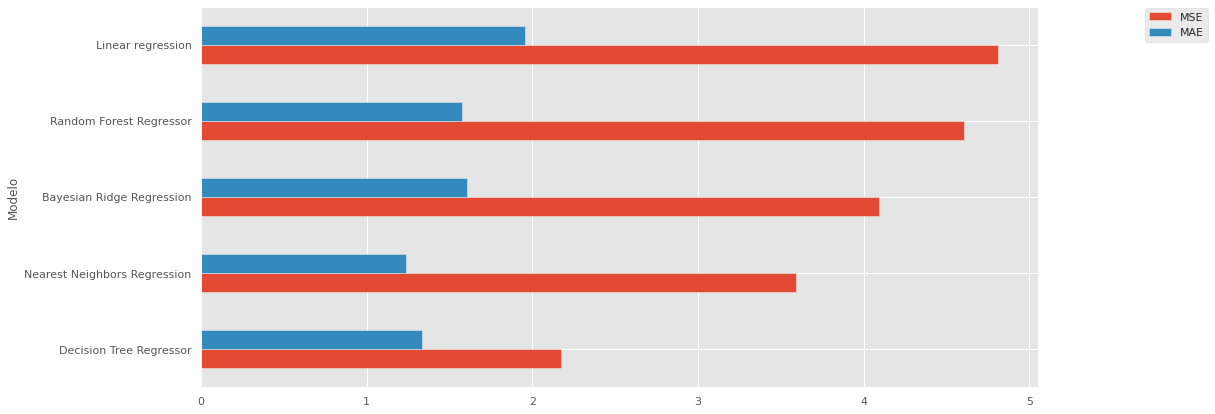

In [61]:
# Avaliação dos modelos 
nomes = ['Linear regression', 'Support Vector Machine', 'Lasso', 'Elastic-Net', 'Bayesian Ridge Regression', 
                                 'Stochastic Gradient Descent', 'Multi-layer Perceptron', 'Passive Aggressive Regressor', 'Nearest Neighbors Regression',
                                 'Gaussian Process Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Gradient Boosting Regressor']

modelos = [Regress_predict, SVM_predict, Lasso_predict, ElasticN_predict, BRR_predict, SGD_predict, MLPerceptron_predict, PAR_predict, 
           NNR_predict, GPR_predict, DTR_predict, RFR_predict, GBR_predict] 

metricas = pd.DataFrame(columns=['Modelo', 'R2', 'MSE', 'MAE', 'MaxError'])
metricas.Modelo = nomes

for i in metricas.index:
  metricas['R2'][i] = get_metrics(y_valid, modelos[i])['R2']
  metricas['MSE'][i] = get_metrics(y_valid, modelos[i])['MSE']
  metricas['MAE'][i] = get_metrics(y_valid, modelos[i])['MAE']
  metricas['MaxError'][i] = get_metrics(y_valid, modelos[i])['MaxError']
metricas.sort_values(by='R2', ascending=False, inplace=True)
metricas.set_index('Modelo', inplace=True)

metricas[:5].plot(kind='barh', y=['MSE', 'MAE'], figsize=(15, 7)).get_legend().set_bbox_to_anchor((1.21, 1.012))
metricas

O melhor modelo (Decision Tree Regressor) obteve um R² de 0.62, com um erro médio de 1,3 dias de tempo de ciclo.


[Text(0, 0.5, 'TC médio semana')]

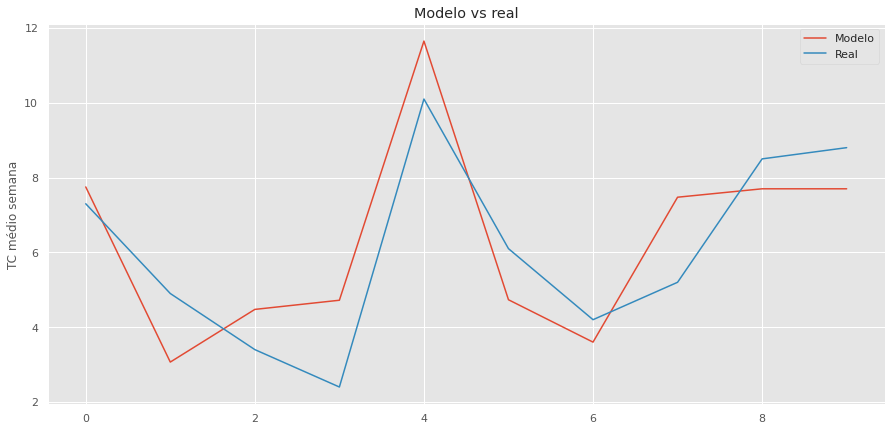

In [62]:
# Melhor modelo
melhor_modelo = DTR

resultado = pd.DataFrame()
resultado['Modelo'] = melhor_modelo.predict(x_valid)
resultado['Real'] = y_valid.values
resultado.plot(figsize=(15, 7), title='Modelo vs real').set(ylabel='TC médio semana')

## 6. Comunicação e Produção

Este modelo é capaz de prever qual será a média móvel de 5 dias do tempo de ciclo para o terceiro dia no futuro, sendo capaz de identificar corretamente a tendência em 62% das vezes e errando, em média, o valor do tempo de ciclo em 1,3 dias.

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Salvando modelo
from sklearn import model_selection
import pickle

arquivo = '/content/drive/My Drive/CWI/Processos/Cocacola/Análises de processo/Tempos/modelo_preditivo_TC_Dojo.sav'
pickle.dump(melhor_modelo, open(arquivo, 'wb'))

In [67]:
# Teste de leitura
loaded_model = pickle.load(open(arquivo, 'rb'))
result = loaded_model.predict(dados3.drop('y', axis=1))
result

array([ 4.72      ,  4.72      ,  2.12      ,  4.72      ,  2.12      ,
        2.8       ,  7.475     ,  7.475     ,  7.475     ,  7.75      ,
        8.7       ,  4.16666667,  3.78571429,  3.78571429,  3.78571429,
        3.78571429,  2.86666667,  3.78571429,  5.1       ,  4.73333333,
        4.475     ,  4.475     ,  4.16666667,  4.475     , 10.2       ,
       11.65      , 12.1       , 11.65      , 12.93333333,  5.8       ,
        4.475     ,  3.6       ,  3.6       ,  2.86666667,  2.12      ,
        2.12      ,  4.73333333, 10.2       , 11.65      ,  7.75      ,
        7.5       ,  2.86666667,  3.06666667,  3.06666667,  4.73333333,
        4.73333333,  7.475     ,  4.72      ,  3.06666667,  3.06666667,
        4.72      ,  5.1       ,  8.7       ,  7.7       ,  7.7       ,
        7.7       ,  8.4       ,  6.5       ,  6.5       ,  6.5       ,
        6.5       , 10.3       , 11.825     , 11.825     , 12.93333333,
       12.93333333,  9.        ,  5.4       ,  5.8       ,  4.3 